In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs
import cartopy as cart
import cmocean
import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch.nn import Sequential as Seq, Linear, ReLU
from Networks import *
from Data_Functions import *
from matplotlib.animation import FuncAnimation
from Utils import *
from Subgrid_Funcs import *
from Eval_Funcs import *
from Parallel import *
import numpy.fft as fft
import sys
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
exp_num_in = "10"
exp_num_extra = "12"
exp_num_out = "6"


mse = torch.nn.MSELoss()
args = {}

region = "global_21"  
network = "U_net_Global"

interval = 1

N_samples = 4000
N_val = 200
N_test = 3000

factor = 10

hist = 0

lag = 1

lam = 100

steps = 3
Nb = 4


lateral = False




if len(sys.argv) > 4:
    n_cond = int((len(sys.argv)-4)/2)

str_video = ""


    
args["Nb"] = Nb    
args["region"] = region
args["network"] = network
args["interval"] = interval
args["N_samples"] = N_samples
args["N_val"] = N_val
args["N_test"] = N_test
args["factor"] = factor
args["hist"] = hist
args["lag"] = lag
args["steps"] = steps
args["str_video"] = str_video
    
    
s_train = lag*hist
e_train = s_train + N_samples*interval
e_test = e_train + interval*N_val



device = "cpu"


inpt_dict = {"1":["um","vm"],"2":["um","vm","ur","vr"],"3":["um","vm","Tm"],
            "4":["um","vm","ur","vr","Tm","Tr"],"5":["ur","vr"],"6":["ur","vr","Tr"],
            "7":["Tm"],"8":["Tm","Tr"],"9":["u","v"],"10":["u","v","T"],
            "11":["tau_u","tau_v"],"12":["tau_u","tau_v","t_ref"]} 
extra_dict = {"1":["ur","vr"],"2":["ur","vr","Tm"],
            "3":["Tm"],"4":["ur","vr","Tm","Tr"],"5":[],"6":["um","vm"],
             "7":["um","vm","Tm"], "8": ["um","vm","Tm","Tr"],
              "9":["ur","vr","tau_u","tau_v"],"10":["tau_u","tau_v"],
              "11":["ur","vr","Tr"],"12":["tau_u","tau_v","t_ref"],
             "13":["ur","vr","Tr","tau_u","tau_v","t_ref"]} 
out_dict = {"1":["um","vm"],"2":["um","vm","Tm"],"3":["ur","vr"],
           "4":["ur","vr","Tr"],"5":["u","v"],"6":["u","v","T"]}

grids = xr.open_dataset('/scratch/as15415/Data/CM2x_grids/Grid_New.nc')




area = torch.from_numpy(grids["area_C"].to_numpy()).to(device=device)





inputs_str = inpt_dict[exp_num_in]
extra_in_str = extra_dict[exp_num_extra]
outputs_str = out_dict[exp_num_out]

str_in = "".join([i + "_" for i in inputs_str])
str_ext = "".join([i + "_" for i in extra_in_str])
str_out = "".join([i + "_" for i in outputs_str])

print("inputs: " + str_in)
print("extra inputs: " + str_ext)
print("outputs: " + str_out)

if lateral:
    
    N_atm = len(extra_in_str)
    N_in = len(inputs_str)
    N_extra = N_atm + N_in
    N_out = len(outputs_str)
else:
    N_atm = len(extra_in_str)
    N_in = len(inputs_str)
    N_extra = N_atm 
    N_out = len(outputs_str)

num_in = int((hist+1)*N_in + N_extra)


inputs, extra_in, outputs = gen_data_global_new(inputs_str,extra_in_str,outputs_str,lag,run_type ="" )

# args["inputs"] = [inputs,inputs ]
# args["extra_in"] = [extra_in,extra_in ]
# args["outputs"] = [outputs,outputs ]

args["inputs"] = [inputs,inputs ]
args["extra_in"] = [extra_in,extra_in ]
args["outputs"] = [outputs,outputs ]

wet = xr.zeros_like(inputs[0][0])
# inputs[0][0,12,12] = np.nan
for data in inputs:
    wet +=np.isnan(data[0])
wet_nan = xr.where(wet!=0,np.nan,1).to_numpy()    
wet = np.isnan(xr.where(wet==0,np.nan,0))
wet = np.nan_to_num(wet.to_numpy())
wet = torch.from_numpy(wet).type(torch.float32).to(device="cpu")
wet_bool = np.array(wet.cpu()).astype(bool)

wet_lap = compute_laplacian_wet(wet_nan,Nb)
wet_lap = xr.where(wet_lap==0,1,np.nan)
wet_lap = np.nan_to_num(wet_lap)
wet_lap = torch.from_numpy(wet_lap).type(torch.float32).to(device=device)

dx = grids["dx"].to_numpy()
dy = grids["dy"].to_numpy()
dy = dy/dx.max()
dx = torch.from_numpy(dx/dx.max()).type(torch.float32)
dy = torch.from_numpy(dy).type(torch.float32)    
    
# args["norm_vals"] = norm_vals

args["s_train"] = s_train
args["e_train"] = e_train
args["e_test"] = e_test
args["wet"] = wet
args["wet_lap"] = wet_lap
args["area"] = area
args["N_extra"] = N_extra
args["N_in"] = N_in
args["N_out"] = N_out
args["N_atm"] = N_atm
args["num_in"] = num_in
args["str_in"] = str_in
args["str_ext"] = str_ext 
args["str_out"] = str_out
args["lateral"] = lateral
args["dx"] = dx
args["dy"] = dy

time_vec = inputs[0].time.data

inputs: u_v_T_
extra inputs: tau_u_tau_v_t_ref_
outputs: u_v_T_


/scratch/as15415/Emulation_ICLR/Data_Functions.py:949: UserWarning: rename 'lat' to 'yt_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yt_ocean","lon":"xt_ocean"})
/scratch/as15415/Emulation_ICLR/Data_Functions.py:949: UserWarning: rename 'lon' to 'xt_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yt_ocean","lon":"xt_ocean"})


In [3]:
data_in_test = gen_data_in_test(0,e_test,N_test,lag,hist,inputs,extra_in)

data_out_test = gen_data_out_test(0,e_test,N_test,lag,hist,outputs)

test_data = data_CNN_Dynamic(data_in_test,data_out_test,wet.to(device = "cpu"),device="cpu") 


time_test = time_vec[e_test:(e_test+lag*N_test)]

mean_out = test_data.norm_vals['m_out']  
std_out = test_data.norm_vals['s_out']  
mean_in = test_data.norm_vals['m_in']  
std_in = test_data.norm_vals['s_in']  

In [4]:

model_pred_5 = xr.open_zarr("/scratch/sd5313/M2Lines/emulator/Ocean_Emulator/Preds/Foundation Swin60 Train1Eval1_Train_global_1_Test_global_1_Test_in_u_v_T_ext_tau_u_tau_v_t_ref__outu_v_T_N_train_4000_Lateral_Data_025_no_smooth/Pred_lateral_Fast_Data_025_global_1_in_u_v_T_ext_tau_u_tau_v_t_ref_N_samples_4000_rand_seed_1.zarr").to_array().to_numpy().squeeze()

In [5]:
Nino34 = grids["x_C"].loc[-5:5,360-170:360-150]
x_ind = [np.argwhere(grids.xu_ocean.data==Nino34["xu_ocean"][0].data),
        np.argwhere(grids.xu_ocean.data==Nino34["xu_ocean"][-1].data)]
x_ind = [x_ind[0][0][0],x_ind[1][0][0]]
y_ind = [np.argwhere(grids.yu_ocean.data==Nino34["yu_ocean"][0].data),
        np.argwhere(grids.yu_ocean.data==Nino34["yu_ocean"][-1].data)]
y_ind = [y_ind[0][0][0],y_ind[1][0][0]]
area_Nino = grids["area_C"].loc[-5:5,360-170:360-150]

In [6]:
clim = inputs[2].loc[:,-5:5,360-170:360-150].groupby('time.dayofyear').mean('time').to_numpy()

In [7]:
T_pred = model_pred_5[:N_test,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1,2]
T_true = test_data[:][1][:,2,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1]
T_true = T_true*std_out[2]+mean_out[2]

In [10]:
def Nino_Index(T,time_test,area):
    T = xr.DataArray(
        data=T,
        dims=["time","yu_ocean", "xu_ocean"],
        coords=dict(
            time=time_test,        
            yu_ocean=(["yu_ocean"], area.yu_ocean.data),
            xu_ocean=(["xu_ocean"], area.xu_ocean.data)

            )
        )
    
    clim = T.groupby('time.dayofyear').mean('time').to_numpy()

    T_clim = T.copy()
    for i in range(time_test.size):
        day = int(time_test[i].dayofyr-1)
        T_clim[i] = (T[i]-clim[day]).data        

    T_clim = T_clim.rolling(time = 150).mean()
    T_clim = (T_clim*area).sum(["xu_ocean","yu_ocean"])/area.sum(["xu_ocean","yu_ocean"])

    return T_clim.to_numpy()



In [11]:
Nino_pred = Nino_Index(T_pred,time_test,area_Nino)
Nino_true = Nino_Index(T_true,time_test,area_Nino)

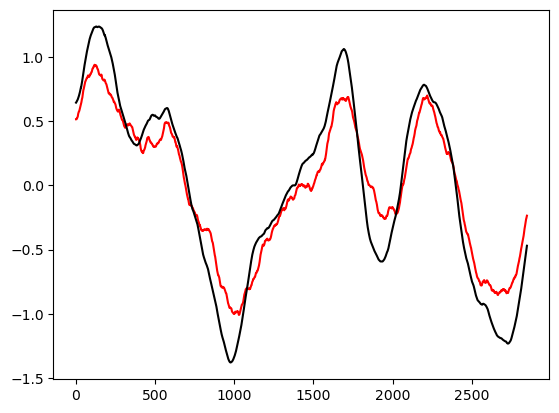

In [12]:
plt.plot(Nino_pred[150:],"r")
plt.plot(Nino_true[150:],"k")